In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Seed untuk reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Parameter
batch_size = 16
img_size = (380, 380)
epochs = 50
learning_rate = 0.0001

In [3]:
# Path dataset
path = '/kaggle/input/gamblingsitesid-img2/gamblingsitesid'
folders = ['judi_resized', 'non-judi_resized']

# Fungsi untuk memuat dataset
def load_dataset(path, folders):
    data = {'imgpath': [], 'labels': []}
    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)
        for file in files:
            filepath = os.path.join(folderpath, file)
            data['imgpath'].append(filepath)
            data['labels'].append(folder)
    return pd.DataFrame(data)

In [4]:
# Memuat dataset
dataset = load_dataset(path, folders)

# Membagi dataset menjadi train, validation, dan test
train_df, temp_df = train_test_split(dataset, train_size=0.8, stratify=dataset['labels'], random_state=seed)
val_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df['labels'], random_state=seed)

In [5]:
# Define the seed, batch size, and image size
seed = 42
batch_size = 16
img_size = (380, 380)

# Define the augmentation configuration with validation split
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalisasi pixel (wajib)
    horizontal_flip=True,      # Bisa terjadi karena tangkapan layar bisa dibalik
    brightness_range=[0.8,1.2], # Variasi pencahayaan
)


# Apply the augmentation to the training data generator
train_data = datagen.flow_from_dataframe(
    train_df,
    x_col='imgpath',
    y_col='labels',
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=True,
    seed=seed
)

# For validation and test data, use a generator without augmentation but with rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

val_data = validation_datagen.flow_from_dataframe(
    val_df,
    x_col='imgpath',
    y_col='labels',
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False
)

test_data = validation_datagen.flow_from_dataframe(
    test_df,
    x_col='imgpath',
    y_col='labels',
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False
)

Found 2055 validated image filenames belonging to 2 classes.
Found 257 validated image filenames belonging to 2 classes.
Found 257 validated image filenames belonging to 2 classes.


In [6]:
from tensorflow.keras.regularizers import l2

# Fungsi untuk membangun model
def build_model(freeze_base=False, use_pretrained=True):
    if use_pretrained:
        base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(380, 380, 3))
    else:
        base_model = EfficientNetB4(weights=None, include_top=False, input_shape=(380, 380, 3))
    
    if freeze_base:
        for layer in base_model.layers:
            layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3, seed=seed),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [7]:
# Callbacks
# callbacks = [
#     EarlyStopping(monitor='val_loss', mode='min',  patience=5, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min',  patience=3, min_lr=1e-6),
#     ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
# ]
def get_callbacks():
    return [
        EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=1e-6),
        ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
    ]

In [8]:
# Eksperimen 1: Tanpa pretrained model (melatih dari awal)
print("Eksperimen 1: Tanpa Pretrained Model")
model_no_pretrain = build_model(freeze_base=False, use_pretrained=False)
history_no_pretrain = model_no_pretrain.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=get_callbacks()
)

Eksperimen 1: Tanpa Pretrained Model
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.6543 - loss: 7.8134 - val_accuracy: 0.5953 - val_loss: 5.9962 - learning_rate: 1.0000e-04
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 67s 503ms/step - accuracy: 0.7124 - loss: 5.2275 - val_accuracy: 0.5953 - val_loss: 4.3612 - learning_rate: 1.0000e-04
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 499ms/step - accuracy: 0.7675 - loss: 3.6004 - val_accuracy: 0.5953 - val_loss: 3.7080 - learning_rate: 1.0000e-04
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 67s 503ms/step - accuracy: 0.8017 - loss: 2.5774 - val_accuracy: 0.5953 - val_loss: 3.7002 - learning_rate: 1.0000e-04
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 67s 503ms/step - accuracy: 0.7849 - loss: 1.9240 - val_accuracy: 0.5953 - val_loss: 2.3498 - learning_rate: 1.0000e-04
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 69s 519ms/step - accuracy: 0.8436 - loss: 1.4189 - val_accuracy: 0.7899 - val_loss: 1.2931 - learning_rate: 1.0000e-04
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 69s 520ms/step - ac

In [9]:
# Evaluasi
test_results_no_pretrain = model_no_pretrain.evaluate(test_data, verbose=0)
print(f"Test Accuracy (No Pretrain): {test_results_no_pretrain[1]:.4f}")

Test Accuracy (No Pretrain): 0.9144


In [10]:
# Eksperimen 2: Fine-tuning hanya fully connected layer (membekukan base model)
print("\nEksperimen 2: Fine-tuning Fully Connected Layer")
model_freeze_base = build_model(freeze_base=True, use_pretrained=True)
history_freeze_base = model_freeze_base.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=get_callbacks()
)


Eksperimen 2: Fine-tuning Fully Connected Layer
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 107s 537ms/step - accuracy: 0.5565 - loss: 7.7121 - val_accuracy: 0.5953 - val_loss: 5.3021 - learning_rate: 1.0000e-04
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 274ms/step - accuracy: 0.5948 - loss: 4.7438 - val_accuracy: 0.5953 - val_loss: 3.3866 - learning_rate: 1.0000e-04
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - accuracy: 0.6046 - loss: 3.0801 - val_accuracy: 0.6070 - val_loss: 2.3213 - learning_rate: 1.0000e-04
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - accuracy: 0.5802 - loss: 2.1435 - val_accuracy: 0.5953 - val_loss: 1.7063 - learning_rate: 1.0000e-04
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 271ms/step - accuracy: 0.5932 - loss: 1.6057 - val_accuracy: 0.5953 - val_loss: 1.3467 - learning_rate: 1.0000e-04
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 277ms/step - accuracy: 0.5734 - loss: 1.2939 - val_accuracy:

In [11]:
# Evaluasi
test_results_freeze_base = model_freeze_base.evaluate(test_data, verbose=0)
print(f"Test Accuracy (Freeze Base): {test_results_freeze_base[1]:.4f}")

Test Accuracy (Freeze Base): 0.5953


In [12]:
# Eksperimen 3: Fine-tuning seluruh jaringan
print("\nEksperimen 3: Fine-tuning Seluruh Jaringan")
model_fine_tune_all = build_model(freeze_base=False, use_pretrained=True)
history_fine_tune_all = model_fine_tune_all.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=get_callbacks()
)


Eksperimen 3: Fine-tuning Seluruh Jaringan
Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.7775 - loss: 7.5937 - val_accuracy: 0.5837 - val_loss: 5.5404 - learning_rate: 1.0000e-04
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 70s 524ms/step - accuracy: 0.9585 - loss: 4.3944 - val_accuracy: 0.6265 - val_loss: 3.3941 - learning_rate: 1.0000e-04
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 70s 524ms/step - accuracy: 0.9642 - loss: 2.5018 - val_accuracy: 0.8093 - val_loss: 1.9512 - learning_rate: 1.0000e-04
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 70s 523ms/step - accuracy: 0.9878 - loss: 1.3469 - val_accuracy: 0.8638 - val_loss: 1.1469 - learning_rate: 1.0000e-04
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 71s 530ms/step - accuracy: 0.9907 - loss: 0.7160 - val_accuracy: 0.9222 - val_loss: 0.6298 - learning_rate: 1.0000e-04
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 73s 546ms/step - accuracy: 0.9966 - loss: 0.3654 - val_accuracy: 0.9611 - val_loss: 0.3298 - learning_rate: 1.0000e-04
Epoc

In [13]:
# Evaluasi
test_results_fine_tune_all = model_fine_tune_all.evaluate(test_data, verbose=0)
print(f"Test Accuracy (Fine-tune All): {test_results_fine_tune_all[1]:.4f}")

Test Accuracy (Fine-tune All): 0.9611


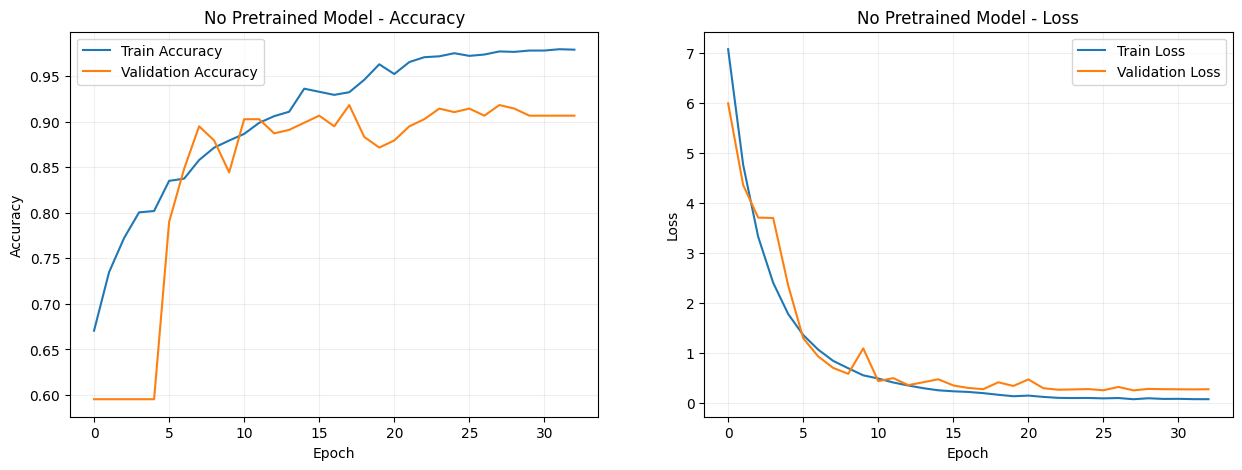

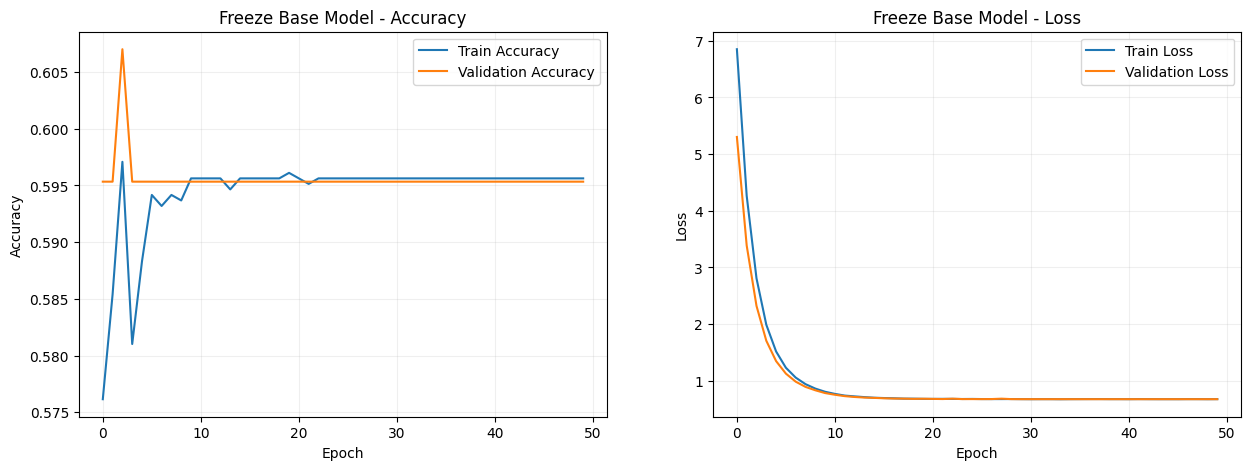

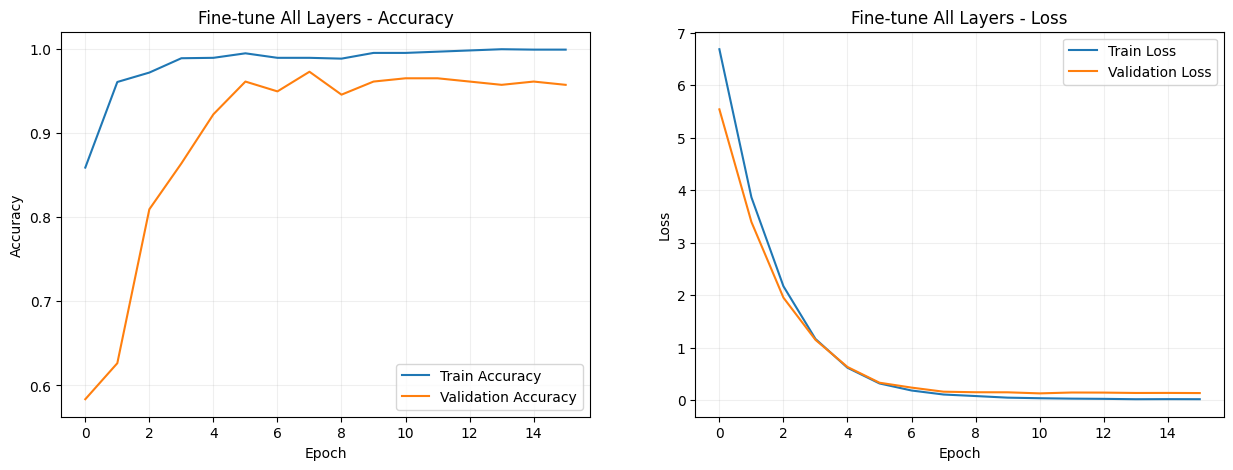

In [14]:
import matplotlib.pyplot as plt

# Fungsi untuk plotting hasil training
def plot_training_history(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title(f'{title} - Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(alpha=0.2)
    
    # Plot loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title(f'{title} - Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(alpha=0.2)
    
    plt.show()

# Plot hasil eksperimen 1: Tanpa pretrained model
plot_training_history(history_no_pretrain, "No Pretrained Model")

# Plot hasil eksperimen 2: Fine-tuning hanya fully connected layer
plot_training_history(history_freeze_base, "Freeze Base Model")

# Plot hasil eksperimen 3: Fine-tuning seluruh jaringan
plot_training_history(history_fine_tune_all, "Fine-tune All Layers")

In [15]:
# Membuat ringkasan hasil
results = {
    "Approach": ["No Pretrained Model", "Freeze Base Model", "Fine-tune All Layers"],
    "Test Accuracy": [
        test_results_no_pretrain[1],
        test_results_freeze_base[1],
        test_results_fine_tune_all[1]
    ],
    "Test Loss": [
        test_results_no_pretrain[0],
        test_results_freeze_base[0],
        test_results_fine_tune_all[0]
    ]
}

# Menampilkan ringkasan hasil
results_df = pd.DataFrame(results)
print(results_df)

               Approach  Test Accuracy  Test Loss
0   No Pretrained Model       0.914397   0.271489
1     Freeze Base Model       0.595331   0.675128
2  Fine-tune All Layers       0.961089   0.143621
